# Controllo Multicanale - onda triangolare

Il programma controlla in tensione i canali specificati nella lista "channels" con uno sweep da "voltage_start'' a ''voltage_stop'' per poi tornare a "voltage_start'', legge le rispettive tensioni e correnti, le salva su file e le visualizza a video con grafici. 

## 1) Import

In [1]:
# Required imports
import sys
username = 'admin' # 'admin' for BO1 lab
sys.path.append('c:/users/'+ username +'/miniconda3/lib/site-packages')
import matplotlib.pyplot as plt
import qontrol
import os
import time
import numpy as np
import datetime
import os.path

%matplotlib inline

## 2) Dichiarazione variabili e setup driver

In [2]:
# Variable declarations
voltage = 8.0
repetitions = 100
channels = [2] # the channels connected to the device
#channels = [k for k in range(10)] # the channels connected to the device
channel_PD = 3 # the channel connected to the photodiode
voltage_PD = 0 # the voltage to be set to the photodiode
voltage_start = [0.0 for j in range(len(channels))] # starting voltage values for each channel
voltage_stop = [voltage for j in range(len(channels))] # stopping voltage values for each channel
voltage_step = [0.2 for j in range(len(channels))] # voltage steps for each channel
max_current = 50 # current compliance
max_voltage = 12 # voltage compliance
measured_voltage = [[[] for i in range(len(channels))] for j in range(len(channels))] # measured_voltage[channels][channel_under_sweep][measurement]
measured_current = [[[] for i in range(len(channels))] for j in range(len(channels))] # current measurements
PD_voltage = [[] for i in range(len(channels))] # PD voltage measurements
PD_current = [[] for i in range(len(channels))] # PD current measurements
F_move_on = 0 # FLAG : 0 for pausing when a channel sweep is done
F_overlapping_plots = 1 # FLAG : 0 for non overlapping plots, not 0 otherwise 
F_triangular = 1 # FLAG : 0 for ramp sweep, 1 for triangular sweep
now = datetime.datetime.now() # retrieve current date and time (for file name)

# Configuration (Laser and Amplifier)
laser_wavelength = 697
laser_power = 5
amplifier_gain = 40

device = "T22T16_" + str(voltage)  + "V_100sweep"

# Set the right path and file
save_path = "G:/Shared drives/FMPS Archive/Projects/0_QPIXPAD/QPX4/Opt.Meas/20210720_Q5_-5/Characterization_tests/"
file_name = "Multiple_channels_control_" + now.strftime("%d_%m_%Y_%H_%M_%S")+ device + '.txt' 
completeName = os.path.join(save_path, file_name)

# Build the header of the file as timestamp+configuration+annotation+voltage_parameters+description
timestamp = '%'+now.strftime("%d/%m/%Y %H:%M:%S")
configuration = '\n%Laser Wavelength:' + str(laser_wavelength) + '[nm]\n%Laser Power:' +str(laser_power) + '[mW]\n%Amplifier Gain:' \
              + str(amplifier_gain) + '[dB]'
# LEFT          RIGHT
# 1              1
# 2              2
# Le misure con annotazione (%Di oggi 20 gennaio da questa in poi sono trans, le altre precedenti erano CIS) sono 1 - 2
# Le misure con annotazione (%Min Scattering Trans) sono 1 - 1
annotation = '\n%2-2\n'

voltage_parameters = '%' # voltage_parameters are voltage_start, voltage_stop, voltage_step, triangular
for element in voltage_start:
    voltage_parameters += str(element) + '\t'
voltage_parameters += '\n%'
for element in voltage_stop:
    voltage_parameters += str(element) + '\t'
voltage_parameters += '\n%'
for element in voltage_step:
    voltage_parameters += str(element) + '\t'
voltage_parameters += '\n%' + str(F_triangular) + '\n'

description = '%Swipe sulla tensione con onda sinusoidale su un canale, canali rimanenti a 0 V.Ciascun canale pilota una termoresistenza.' + device
header = timestamp+configuration+annotation+voltage_parameters+description

# Write the header and the column headers to the file
meas_file = open(completeName, "a")
meas_file.write(header)
meas_file.write("%PD at channel " + str(channel_PD) + ": Voltage [V]\tCurrent [mA]")
for j in range(len(channels)):
    meas_file.write("\tChannel " +str(channels[j]) + " : Voltage [V]\tCurrent [mA]")
meas_file.write("\n")


# Setup Qontroller
serial_port_name = "COM3" #"COM3" #"/dev/tty.usbserial-FT06QAZ5" # name of the USB Serial Port #//./COM11
q = qontrol.QXOutput(serial_port_name = serial_port_name, response_timeout = 0.1)

# Set the compliances
for channel in range(q.n_chs):
    q.imax[channel] = max_current
    q.vmax[channel] = max_voltage

# Video Debugging
print ("Qontroller '{:}' initialised with firmware {:} and {:} channels".format(q.device_id, q.firmware, q.n_chs) )

Qontroller 'Q8b-0471' initialised with firmware v2.4.1 and 16 channels


## 3) Acquisizione e visualizzazione dati


DRIVING CHANNEL 2 NOW 

Qontroller.issue_command: Warning: Response to write command I15=0 timed out.


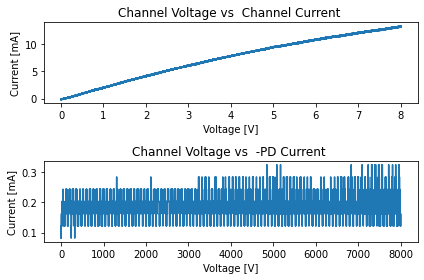

In [3]:
# PD voltage setting
q.v[channel_PD] = voltage_PD

#Set current for channel K
#q.i[K] = I

skipped_channels = [] # keep tracks of skipped channels (so it knows what columns to skip)

# Perform a voltage sweep for each channel    
for channel_n in range(len(channels)):
    
    F_move_on = 1 #int(input("Do you want to move to channel " + str(channels[channel_n]) + "? Skip -> 0 Do the swipe -> 1\n"))  
    if F_move_on == 1: # ask wheter to execute or skip current swipe

        print("\nDRIVING CHANNEL {:} NOW \n" .format(channels[channel_n]))

        # set all channels to their voltage_start values
        for k in range(len(channels)):
            q.v[channels[k]] = float(voltage_start[k])

        #check if we want to generate a triangular sweep or not
        if F_triangular == 1:
            sweep_range = np.concatenate((np.arange(voltage_start[channel_n], voltage_stop[channel_n], voltage_step[channel_n]),\
                            np.arange(voltage_stop[channel_n], voltage_start[channel_n], -voltage_step[channel_n])))
        elif F_triangular == 0:
            sweep_range = np.arange(voltage_start[0], voltage_stop[0]+voltage_step[0], voltage_step[0])
        else:
            print('invalid value for triangular')
        for z in range(repetitions):
            for voltage_sweep in sweep_range: 
                q.v[channels[channel_n]] = float(voltage_sweep)
                temp_voltage = q.v[channel_PD]
                temp_current = -q.i[channel_PD]
                PD_voltage[channel_n].append(temp_voltage)
                PD_current[channel_n].append(temp_current)
                #print("PD [ch {:}] : Voltage -> {:} V, Current -> {:} mA" .format(channel_PD, temp_voltage, temp_current))
                meas_file.write('{:+010.6f}\t{:+010.6f}' .format(temp_voltage,  temp_current))

                for j in range(len(channels)): # acquire voltage and current for all channels. Then print them on screen and save them on file
                    temp_voltage = q.v[channels[j]]
                    temp_current = q.i[channels[j]]
                    measured_voltage[j][channel_n].append(temp_voltage)
                    measured_current[j][channel_n].append(temp_current)
                    #print("Channel {:} : Voltage -> {:} V, Current -> {:} mA" .format(channels[j], temp_voltage, temp_current))
                    meas_file.write("\t{:+010.6f}\t{:+010.6f}" .format(temp_voltage, temp_current))
                meas_file.write("\n")


        # at the end of each sweep, set all channels to their voltage_start values
        for k in range(len(channels)):
            q.v[channels[k]] = float(voltage_start[k])
    else:
        continue

# Plot results
fig, axs = plt.subplots(2,1)

axs[0].set_title('Channel Voltage vs  Channel Current ')
axs[0].set_xlabel('Voltage [V]')
axs[0].set_ylabel('Current [mA]')
axs[1].set_title('Channel Voltage vs  -PD Current ')
axs[1].set_xlabel('Voltage [V]')
axs[1].set_ylabel('Current [mA]')

for i in range(len(channels)):
    #print("\nPLOTS FOR DRIVING CHANNEL {:} \n" .format(channels[i]))
    if F_overlapping_plots == 0:
        axs[0].plot(range(i*len(measured_current[i][i]),(i+1)*len(measured_current[i][i])), measured_current[i][i])
        axs[1].plot(range(i*len(measured_current[i][i]),(i+1)*len(measured_current[i][i])), PD_current[i])
    else:
        axs[0].plot(measured_voltage[i][i], measured_current[i][i])
        axs[1].plot(range(len(measured_current[i][i])), PD_current[i])
plt.tight_layout()


# Close the log file
meas_file.close()

# Set all channels to zero
q.v[:] = 0
q.i[:] = 0

# Close the communication with the driver
q.close()